# WISER Quantum for Portfolio Optimization

Given certain constraints and the objective function, The goal is to assign binary values to select a bond among 31 bonds. This notebook is a basic runthrough of how this problem can be solved by the Variational Quantum Eigensolver (VQE) algorithm. VQE is used along with CVaR to optimize the result (Barkoutsos et al., 2020).


## Standard VQE

After translating a problem into QUBO form and constructing a Hamiltonian for an n-qubit system, the standard VQE algorithm samples (i.e., indirectly measures) the Hamiltonian *K* times. These measurement outcomes are summed and averaged to estimate the expectation value $\langle \psi(\theta) | H | \psi(\theta) \rangle$. The lowest expectation value, corresponding to a specific set of parameters in the chosen ansatz that minimizes the cost function, is taken as the optimal solution (bitstring) with high probability.

## CVaR-VQE

In contrast, CVaR-VQE optimizes a conditional value-at-risk (CVaR) objective, focusing on the average of the worst $\alpha$-fraction of sampled energies. The minimal CVaR value, corresponding to certain ansatz parameters minimizing this objective, is considered the optimal solution (bitstring).


## Preparing Path

Adding the root directory to <code>sys.path</code> can import the project's modules regardless of where the notebook is located in the folder hierarchy.

In [1]:
import os
import sys
from pathlib import Path

ROOT = Path(os.getcwd()).parent
print(ROOT)

sys.path.append(str(ROOT))

C:\Users\ASUS\Desktop\WISER_Optimization_VG


## Importing Libraries

In [29]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from dataclasses import asdict

from qiskit_aer import AerSimulator
from qiskit.circuit.library import n_local

from src.sbo.src.utils.lp_utils import load_quadratic_program # for problem conversion
from src.sbo.src._converters.quadratic_program_to_qubo import QuadraticProgramToQubo # for problem conversion
from src.sbo.src.patterns.building_blocks.step_3 import HardwareExecutor # for hardware executor
from src.experiment import Experiment # for saving the experiment result

## Converting the Problem into QUBO

The 31-bond problem is initially defined by an LP file. This LP file is then converted into a quadratic function, which is subsequently transformed into a Quadratic Unconstrained Binary Optimization (QUBO) problem using the predefined modules.

In [3]:
# Read the LP file directly
lp_file_path = str(ROOT)+'/data/1/31bonds/docplex-bin-avgonly-nocplexvars.lp'

# Convert LP file into quadratic problem
quadratic_problem = load_quadratic_program(lp_file_path)

# Convert quadratic program into QUBO
converter = QuadraticProgramToQubo()
qubo = converter.convert(quadratic_problem)

In [4]:
print(f"31-bond problem: {quadratic_problem.get_num_binary_vars()} binary variables")
print(f"QUBO variables: {qubo.get_num_vars()}")

31-bond problem: 31 binary variables
QUBO variables: 31


## Implementing the Objective Function

The objective function is given by the formula:

$$
\min \sum_{\ell \in L} \sum_{j \in J} \rho_j \left( \sum_{c \in K_\ell} \beta_{c,j} \, x_c - K_{\ell,j}^{\text{target}} \right)^2
$$

Its goal is to minimize the difference between a portfolio's characteristics and their target values, ensuring the portfolio matches the targets as closely as possible.

This objective function is handled internally by the QUBO formulation.

In [5]:
# Create objective function using the QUBO's evaluate method
def objective_function(x):
    """Objective function for the QUBO problem"""
    return qubo.objective.evaluate(x)

In [6]:
# Print the QUBO structure
num_vars = qubo.get_num_vars()

print(f"Number of variables: {num_vars}")
print(f"Constant term: {qubo.objective.constant}")
print(f"QUBO objective sense: {qubo.objective.sense}")

Number of variables: 31
Constant term: 0.0
QUBO objective sense: ObjSense.MINIMIZE


## Implementing the Backend Device and Ansatz Circuit

In this notebook, there are two types of backend devices: a simulator and a real quantum hardware device.

The ansatz is a parameterized quantum circuit capable of generating a wide range of quantum states. By adjusting the parameters, the quantum state evolves. For each state, repeated measurements yield observed energy values. Instead of averaging all energies, CVaR-VQE computes the average of the lowest $\alpha$-fraction of energies to estimate the CVaR cost.

The goal of the ansatz is to find the set of parameters that prepares a quantum state such that the CVaR is minimized. The **two-local full entanglement ansatz** is chosen for this portfolio optimization problem because it provides a very good expressibility, allowing the quantum circuit to represent complex correlations between qubits. Moreover, tunable couplers in the **Ankaa architecture** can facilitates dynamic control over qubit interactions (Mutus, 2025). This advancement eases the implementation of fully entangled circuits, such as the two-local full entanglement ansatz, making them more practical on real quantum hardware.

In [7]:
# Define the function
def get_backend(device: str, instance: str, num_vars: int):
    if device == 'AerSimulator': # choose simulation
        aer_options={'method' : 'matrix_product_state', 'n_qubits': num_vars}
        backend = AerSimulator(**aer_options)
    elif device[:4] == 'ibm_': # choose real hardware
        service = QiskitRuntimeService()
        backend = service.backend(device, instance)
    else:
        raise ValueError('unknown device')
    
    return backend

# Create the backend device
backend = get_backend('AerSimulator', '', num_vars)

In [8]:
# Define the function
def build_ansatz(ansatz: str, ansatz_params: dict, num_qubits: int, get_backend):
    """
    Build ansatz following SBO framework pattern
    """
    if ansatz == 'TwoLocal':
        ansatz_params_ = {
            'rotation_blocks': 'ry', 
            'entanglement_blocks': 'cz', 
            'entanglement': 'full', 
            'reps': 2
        }
        ansatz_params_.update(ansatz_params)
        
        ansatz_ = n_local(num_qubits, **ansatz_params_)
        ansatz_.measure_all()
        return ansatz_, None
    
    else:
        raise ValueError('unknown ansatz')

# Create the ansatz
ansatz_params = {'reps': 2, 'entanglement': 'full'}
ansatz, initial_layout = build_ansatz('TwoLocal', ansatz_params, num_vars, get_backend)
print(f"Ansatz has {ansatz.num_parameters} parameters")

Ansatz has 93 parameters


## Conditional Value at Risk (CVaR)

CVaR is a generalization of both the sample mean and the minimum. It represents the expected value of the lowest α-fraction (i.e., the lower tail) of a distribution. In this case, the distribution of sampled energy values from a quantum Hamiltonian.

According to Barkoutsos et al. (2020), to compute CVaR:

- The Hamiltonian is sampled (measured indirectly) *K* times.
- Each sample yields an energy value.
- The energy values are sorted in ascending order (lowest to highest).
- CVaR is then calculated as the average of the lowest ⌈αK⌉ values using the formula:

$$
\text{CVaR}_\alpha = \frac{1}{\lceil \alpha K \rceil} \sum_{k=1}^{\lceil \alpha K \rceil} H_k
$$

Here, $H_k$ denotes the k-th lowest observed energy value.

In implementation:

- The CVaR calculation is performed by the function <code>calc_cvar()</code> in <code>"src/sbo/src/patterns/building_blocks/step3.py"</code>.
- Sampled measurement results are mapped to energy values by the function <code>_sampler_result_to_cvar()</code> in <code>"src/sbo/src/patterns/building_blocks/step3.py"</code>.

## Implementing the Hardware Executor

In [9]:
# Initial parameters (π/3 as used in the reference)
theta_initial = np.pi/3 * np.ones(ansatz.num_parameters)

# CVaR parameters
alpha = 0.1  # CVaR parameter (0.1 = 10% worst cases)
shots = 1024  # Number of shots

# Create HardwareExecutor
he = HardwareExecutor(
    objective_fun=objective_function,
    backend=backend,
    isa_ansatz=ansatz,
    optimizer_theta0=theta_initial,
    optimizer_method="nft",  # NFT optimizer as used in references
    refvalue=None,  # No reference value for now
    sampler_options={'default_shots': shots},
    use_session=False,  # No session for simulation
    verbose="progress",  # Show progress
    file_name=None,
    store_all_x=True,  # Store all solutions
    solver_options={
        "max_epoch": 10,  # Maximum epochs
        "alpha": alpha,   # CVaR parameter
        "random_update": True  # Random parameter updates
    }
)

## Simulation



In [10]:
# Run the optimization
print("Starting VQA optimization with CVaR...")
start_time = time.time()

result = he.run()

end_time = time.time()
print(f"Optimization completed in {end_time - start_time:.2f} seconds")

# Get the best solution
best_x = he.optimization_monitor.objective_monitor.best_x
best_fx = he.optimization_monitor.objective_monitor.best_fx

print(f"Best solution: {best_x}")
print(f"Best objective value: {best_fx}")

2025-08-11 09:33:29,140 INFO optimization_wrapper: run...
2025-08-11 09:33:29,145 DEBUG optimization_wrapper: Using X0 [1.04719755 1.04719755 1.04719755 1.04719755 1.04719755 1.04719755
 1.04719755 1.04719755 1.04719755 1.04719755 1.04719755 1.04719755
 1.04719755 1.04719755 1.04719755 1.04719755 1.04719755 1.04719755
 1.04719755 1.04719755 1.04719755 1.04719755 1.04719755 1.04719755
 1.04719755 1.04719755 1.04719755 1.04719755 1.04719755 1.04719755
 1.04719755 1.04719755 1.04719755 1.04719755 1.04719755 1.04719755
 1.04719755 1.04719755 1.04719755 1.04719755 1.04719755 1.04719755
 1.04719755 1.04719755 1.04719755 1.04719755 1.04719755 1.04719755
 1.04719755 1.04719755 1.04719755 1.04719755 1.04719755 1.04719755
 1.04719755 1.04719755 1.04719755 1.04719755 1.04719755 1.04719755
 1.04719755 1.04719755 1.04719755 1.04719755 1.04719755 1.04719755
 1.04719755 1.04719755 1.04719755 1.04719755 1.04719755 1.04719755
 1.04719755 1.04719755 1.04719755 1.04719755 1.04719755 1.04719755
 1.0471975

Starting VQA optimization with CVaR...


2025-08-11 09:33:32,944 INFO optimization_monitor: optimizer internal status: () {'idx_set': array([41, 23, 69, 38, 10, 88, 19, 78, 80, 30, 60, 52, 58, 75, 76, 53, 29,
       43, 70, 28, 90, 37, 42, 59, 49, 61, 44, 55, 92, 40, 68,  8, 56, 27,
       36, 16,  7, 24, 63, 64,  3, 26, 35, 11, 12,  0, 50, 62, 17, 31, 91,
       72, 73, 39, 54, 86, 21, 18, 13,  1, 85, 84, 46, 74, 57, 32, 34, 22,
        9, 87, 45, 51, 82, 15, 33, 89,  4, 79, 14, 20, 48,  5, 81, 65, 71,
       66,  2,  6, 47, 83, 67, 77, 25]), 'epoch': 0, 'iter_in_epoch': 0, 'update': None, 'new_core_eval': True}
2025-08-11 09:33:35,858 INFO optimization_monitor: optimizer internal status: () {'idx_set': array([41, 23, 69, 38, 10, 88, 19, 78, 80, 30, 60, 52, 58, 75, 76, 53, 29,
       43, 70, 28, 90, 37, 42, 59, 49, 61, 44, 55, 92, 40, 68,  8, 56, 27,
       36, 16,  7, 24, 63, 64,  3, 26, 35, 11, 12,  0, 50, 62, 17, 31, 91,
       72, 73, 39, 54, 86, 21, 18, 13,  1, 85, 84, 46, 74, 57, 32, 34, 22,
        9, 87, 45, 51, 82, 

Optimization completed in 2401.39 seconds
Best solution: [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0.]
Best objective value: -2237.1308551437114


## Saving the Result

The result of the experiment (execution) is saved with the predefined modules.

In [26]:
# Set path
experiment_path = Path(str(ROOT)+"/project/exp_portfolio_vqa.pkl")

In [27]:
# Create an Experiment object from the results
experiment = Experiment.from_step3(
    experiment_id="portfolio_vqa_run",
    ansatz="TwoLocal",
    ansatz_params={'reps': 2, 'entanglement': 'full'},
    theta_initial="piby3",
    device="AerSimulator",
    optimizer="nft",
    alpha=alpha,
    theta_threshold=None,
    lp_file="31bonds/docplex-bin-avgonly-nocplexvars.lp",
    shots=shots,
    refx=None,  # set this for a reference solution
    refvalue=None,  # set this for a reference value
    classical_hw=Experiment.get_current_classical_hw(),
    step3_time=end_time - start_time,
    step3_job_ids=he.job_ids,
    result=result,
    optimization_monitor=he.optimization_monitor
)

# Save the experiment for analysis
experiment_path.parent.mkdir(parents=True, exist_ok=True)
with open(experiment_path, 'wb') as f:
    pickle.dump(asdict(experiment), f)

## Analysis

=== Portfolio Optimization Results ===
Best solution: [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0.]
Best objective value: -2237.1308551437114
Number of iterations: 931
Number of selected bonds: 24.0


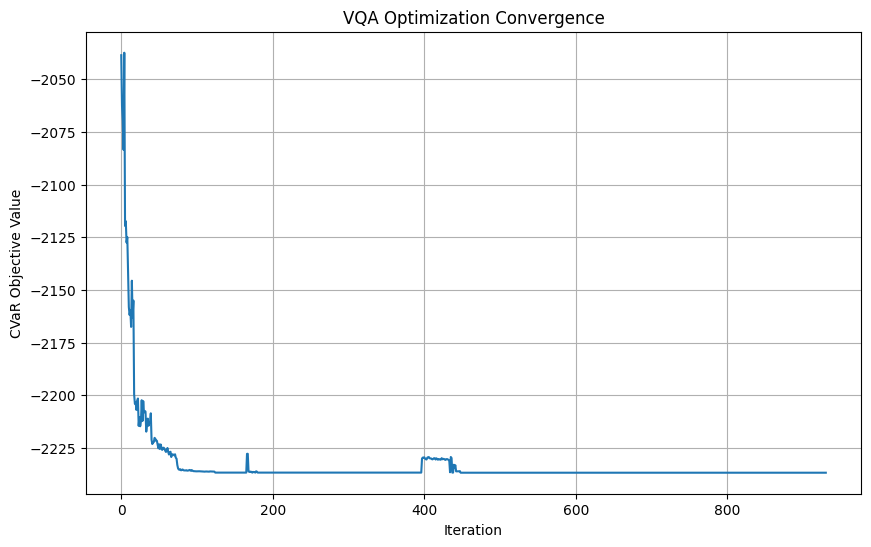

In [30]:
# Do simple analysis
if 'he' in locals() and hasattr(he, 'optimization_monitor'):
    current_best_x = he.optimization_monitor.objective_monitor.best_x
    current_best_fx = he.optimization_monitor.objective_monitor.best_fx
    current_iterations = len(he.optimization_monitor.list_callback_res)
    
    print(f"=== Portfolio Optimization Results ===")
    print(f"Best solution: {current_best_x}")
    print(f"Best objective value: {current_best_fx}")
    print(f"Number of iterations: {current_iterations}")
    print(f"Number of selected bonds: {sum(current_best_x)}")
    
    # Simple convergence plot
    if len(he.optimization_monitor.list_callback_res) > 0:
        plt.figure(figsize=(10, 6))
        plt.plot(he.optimization_monitor.list_callback_res)
        plt.xlabel('Iteration')
        plt.ylabel('CVaR Objective Value')
        plt.title('VQA Optimization Convergence')
        plt.grid(True)
        plt.show()
else:
    print("HardwareExecutor not available")

# References

- Barkoutsos, P. K., Nannicini, G., Robert, A., Tavernelli, I., & Woerner, S. (2020). Improving variational quantum optimization using CVaR. *Quantum, 4*, 256. https://doi.org/10.22331/q-2020-04-20-256
- Mutus, J. (2025, July 17). *Quantum hardware demystified ❯ Dr. Josh Mutus ❯ 2025 QUANTUM PROGRAM* [Video]. YouTube. https://youtu.be/EIL2MEvyGp8
- Project Slides